In [150]:
import boto3
import requests
import configparser
import re

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

In [70]:
# api keys are in config.ini to keep them out of github
config = configparser.ConfigParser()
config.read('config.ini')
try:
    APP_ID = config['facebook']["APP_ID"]
    PAGE_ACCESS_TOKEN = config['facebook']["PAGE_ACCESS_TOKEN"]
    VERIFY_TOKEN = config['facebook']["VERIFY_TOKEN"]
    APP_SECRET = config['facebook']["APP_SECRET"]
    PAGE_ID = config['facebook']["PAGE_ID"]
    aws_access_key_id = config['amazon']['aws_access_key_id']
    aws_secret_access_key = config['amazon']['aws_secret_access_key']
    PLACES_API = config['google']['PLACES_API']

except KeyError:
    print("Missing keys in the config.ini file")

In [52]:
data = pd.read_csv("data/pocketbook-export.csv")
data.head()

,date,description,category,amount,notes,tags,bank,accountname,accountnumber
0,01/09/2012,Credit Interest,Bank - Interest,1.95,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497
1,08/09/2012,Parentalleavepay Tp1s4177210293941c,NaN,309.90,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497
2,22/09/2012,Parentalleavepay Tp1s4527210293941c,NaN,1032.00,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497
3,26/09/2012,Parentalleavepay Tp1s4597210293941c,NaN,206.60,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497
4,01/10/2012,Credit Interest,Bank - Interest,3.57,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497


In [53]:
data = data.join(data.category.str.split(" - ", expand=True))
data.head()

,date,description,category,amount,notes,tags,bank,accountname,accountnumber,0,1
0,01/09/2012,Credit Interest,Bank - Interest,1.95,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,Bank,Interest
1,08/09/2012,Parentalleavepay Tp1s4177210293941c,NaN,309.90,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,NaN,None
2,22/09/2012,Parentalleavepay Tp1s4527210293941c,NaN,1032.00,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,NaN,None
3,26/09/2012,Parentalleavepay Tp1s4597210293941c,NaN,206.60,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,NaN,None
4,01/10/2012,Credit Interest,Bank - Interest,3.57,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,Bank,Interest


In [64]:
data.rename(columns={0: "Category", 1: "Subcategory"}, inplace=True)
data.head()

,date,description,category,amount,notes,tags,bank,accountname,accountnumber,Category,Subcategory
0,01/09/2012,Credit Interest,Bank - Interest,1.95,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,Bank,Interest
1,08/09/2012,Parentalleavepay Tp1s4177210293941c,NaN,309.90,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,NaN,None
2,22/09/2012,Parentalleavepay Tp1s4527210293941c,NaN,1032.00,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,NaN,None
3,26/09/2012,Parentalleavepay Tp1s4597210293941c,NaN,206.60,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,NaN,None
4,01/10/2012,Credit Interest,Bank - Interest,3.57,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497,Bank,Interest


In [68]:
data.drop(["notes", "tags", "bank", "accountname", "accountnumber", "category"], inplace=True, axis=1)
data.head(100)

ValueError: labels ['notes' 'tags' 'bank' 'accountname' 'accountnumber' 'category'] not contained in axis

In [69]:
data.head(100)

,date,description,amount,Category,Subcategory
0,01/09/2012,Credit Interest,1.95,Bank,Interest
1,08/09/2012,Parentalleavepay Tp1s4177210293941c,309.90,NaN,None
2,22/09/2012,Parentalleavepay Tp1s4527210293941c,1032.00,NaN,None
3,26/09/2012,Parentalleavepay Tp1s4597210293941c,206.60,NaN,None
4,01/10/2012,Credit Interest,3.57,Bank,Interest
5,18/10/2012,Kaching Mo,-1000.00,Transferring Money,None
6,23/10/2012,Broken Bank,-1000.00,Transferring Money,None
7,01/11/2012,Credit Interest,4.22,Bank,Interest
8,01/12/2012,Credit Interest,0.58,Bank,Interest
9,13/12/2012,Bankruptcy,-200.00,Transferring Money,None


you spent 85.0 at Amazon


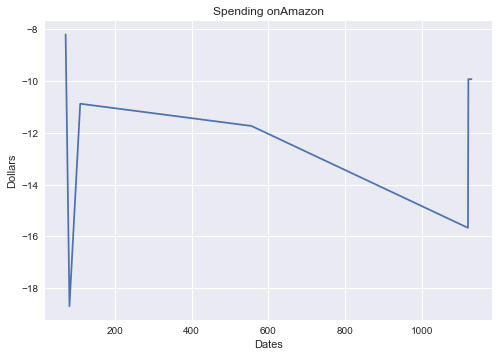

In [48]:
# ignoring the date for now
what="Amazon"

if what in data.category.values:
    total_spend = -data[data.category.values == what]["amount"].sum()

    # lets tell the user how much was spent on this category
    msg = f"you spent {total_spend} at {what}"
    print(msg)
    
    # lets plot something
    plt.plot(data[data.category.values == what]["amount"])
    plt.title("Spending on" + what)
    plt.xlabel("Dates"), plt.ylabel("Dollars")

In [161]:
country = "Australia"
query = "Aldi Broadway" 
url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
payload= {"query": query+" "+country, "key": PLACES_API}
r = requests.get(url, params=payload)
if r.json()["results"] != []:
    place = r.json()["results"][0]
else:
    print("Returned no result")
    
address = place['formatted_address']
location = place['geometry']['location']
place_id = place['place_id']
types = place['types']

address, location, place_id, types

('1 Broadway, NSW 2007, Australia',
 {'lat': -33.8837143, 'lng': 151.1938614},
 'ChIJXT5kmCmuEmsRqEhdB4Br0Pw',
 ['liquor_store',
  'grocery_or_supermarket',
  'food',
  'store',
  'point_of_interest',
  'establishment'])

In [158]:
place

{'formatted_address': '69 Lower Fort St, Dawes Point NSW 2000, Australia',
 'geometry': {'location': {'lat': -33.8573777, 'lng': 151.2064332},
  'viewport': {'northeast': {'lat': -33.8560287197085,
    'lng': 151.2077821802915},
   'southwest': {'lat': -33.8587266802915, 'lng': 151.2050842197085}}},
 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/generic_business-71.png',
 'id': '05f8e48538576a87be8bc447f6bb93db794b8d68',
 'name': 'Amazon Australia warehouse',
 'place_id': 'ChIJ6_xWzlyuEmsRujrWU87Oppo',
 'reference': 'CmRSAAAAdkHcsO0YYBAJKhCgdPiG5vAKMeAJEUnkeBE72vfqmEt6mFwooRzf_q2ioJJ_S8p6-96X1Ia-Tm8TXcbUC4qeqlOw-na8W6vV2wz3rIlrGqWt_ocufsDMf2Un2osKUhGjEhD6zhesqk1mSSmJipIyjnxaGhSAdTWe7DO7tkiN5BJQZWhd33uF_g',
 'types': ['storage', 'point_of_interest', 'establishment']}

In [ ]:
places_info = {}

def get_place_info(query="Aldi Broadway"):
    """takes in a text and returns a google place lookup"""
    
    # return from dict if already looked this up
    if query.lower() in places_info:
        return places_info[query.lower()]
    
    # find the lat long 
    url = "http://nominatim.openstreetmap.org/search"
    payload = {"format": "json", "q": query, "country": "Pakistan", "limit": 1}
    r = requests.get(url, params=payload)
    
    try:
        d = r.json()[0]
    except:
        return False
    
    return float(d["lat"]), float(d["lon"])
    
cities = ["karachi", "lahore", "islamabad", "peshawar"]
cities_loc = {city: get_lat_long(city) for city in cities}
cities_loc

In [151]:
s = "Amazon Servicesk8662161072 Usd000000001099"
s

'Amazon Servicesk8662161072 Usd000000001099'

In [155]:
re.search("Usd", s)

<_sre.SRE_Match object; span=(27, 30), match='Usd'>